# Thesis

In [30]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from grid_cells import get_grid_cells, purge_delinquent_cells
from environment import Environment # GridCellWorld
from utils import get_coords, device, to_tensor
from agent import Agent
from torch.optim import Adam
from tqdm import tqdm

In [2]:
class GridCellWorld(Environment):
    def __init__(self, grid_cells, coords, max_velocity=None):
        self.grid_cells = grid_cells
        self.coords = coords
        self.bounds = (self.coords.min(), self.coords.max())
        self.max_velocity = np.array(self.bounds) / 10 if max_velocity is None else max_velocity
    
    def reset(self, end_point=None, end_radius=None):
        dim = self.coords.shape[-1]
        self.end_point = np.zeros(dim) if end_point is None else end_point
        self.end_radius = np.diff(self.bounds).item() / 20 if end_radius is None else end_radius
        # self.velocity = np.zeros(dim)
        self.state = np.random.uniform(*self.bounds, dim)
        while self.done():
            self.state = np.random.uniform(*self.bounds, dim)
        # self.state = np.random.choice([-1, 1], 2)
        return self.get_state()
        
    # def next_state(self, acceleration):
        # self.velocity = np.clip(self.velocity + acceleration, *self.max_velocity)
    def next_state(self, action):
        self.state = np.clip(self.state + action, *self.bounds)
        return self.get_state(), self.reward(), self.done()
    
    def get_state(self):
        # return np.concatenate([self.velocity, self.grid_cells[self.closest_coord_index(self.state)]])
        return self.grid_cells[self.closest_coord_index(self.state)]
        # return self.state
    
    def closest_coord_index(self, coord):
        return np.unravel_index(np.abs(self.coords - coord).sum(axis=-1).argmin(), self.coords.shape[:2])
    
    def done(self):
        return np.sum((self.state - self.end_point)**2) <= self.end_radius**2
    
    def reward(self):
        dim = self.coords.shape[-1]
        corners = np.array(np.meshgrid(*[self.bounds] * dim)).T.reshape(-1, dim)
        max_dist = np.sum((self.end_point - corners)**2, axis=-1).max()
        reward = -np.sqrt(np.sum((self.state - self.end_point)**2) / max_dist)
        return 1 if self.done() else reward

In [3]:
resolution = 400
MIN, MAX = -1, 1
N = 100

coords = get_coords(resolution, MIN, MAX)
# grid_cells = get_grid_cells(np.linspace(40, 150, 30), N, resolution)
# grid_cells = purge_delinquent_cells(grid_cells)
grid_cells = np.load("grid_cells.npy")

In [4]:
env = GridCellWorld(grid_cells, coords)
agent = Agent(grid_cells.shape[-1], 2, action_amp=0.1, bs=256, actor_hidden=512, critic_hidden=1024)

In [105]:
hidden = 100

net = nn.Sequential(
    nn.Linear(grid_cells.shape[-1], hidden),
    nn.Sigmoid(),
    nn.Linear(hidden, 2),
    nn.Tanh()
).to(device)

optim = Adam([p for p in net.parameters()], lr=3e-4, weight_decay=1e-5)

In [27]:
def get_batch(coords, grid_cells, bs=64):
    states = torch.rand(bs, 2, device=device) * 2 - 1
    distances = torch.abs(torch.unsqueeze(coords, 2) - states).sum(axis=-1)
    idx = distances.view(-1, bs).argmin(0)
    rr = idx // coords.shape[0]
    cc = idx % coords.shape[1]
    return grid_cells[(rr, cc)], states

In [8]:
c, gc = to_tensor(coords), to_tensor(grid_cells)

In [106]:
losses = list()
for _ in tqdm(range(1000)):
    optim.zero_grad()
    x, y = get_batch(c, gc, bs=256)
    loss = torch.sum((net(x) - y)**2, dim=-1).mean()
    loss.backward()
    optim.step()
    losses.append(loss.detach().cpu().item())

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.66it/s]


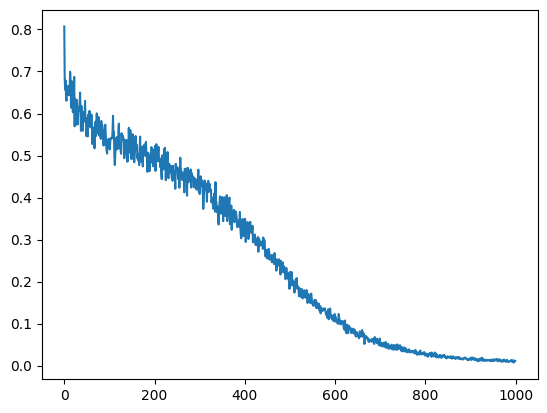

In [107]:
plt.plot(losses)
plt.show()

In [108]:
idx = net[2].weight.detach().cpu().abs().argsort(dim=-1)[:,-10:].numpy() + [[0], [hidden]]
net[2].weight.detach().cpu().flatten()[idx.flatten()]

tensor([-0.1708, -0.1758, -0.1762, -0.1787, -0.1827, -0.1886, -0.1894,  0.2017,
        -0.2071, -0.2187, -0.1605, -0.1619,  0.1689, -0.1762, -0.1770, -0.1782,
         0.1856, -0.1924, -0.1940, -0.1943])

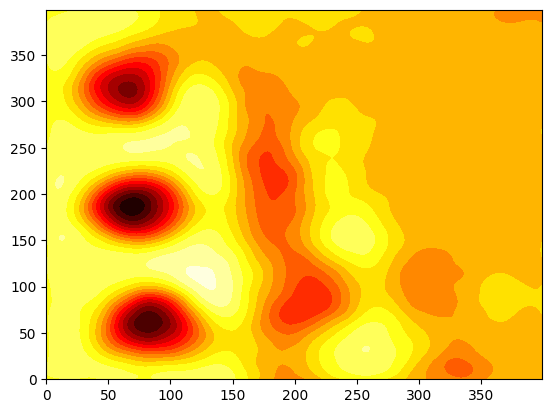

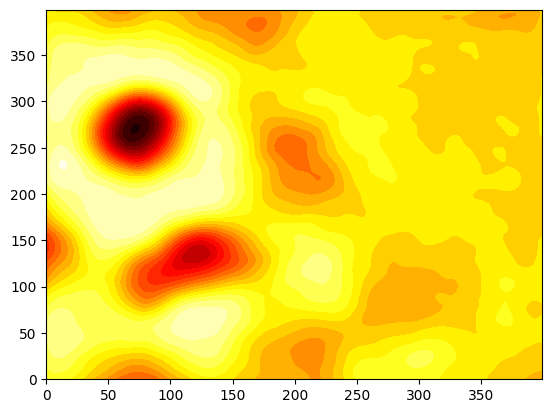

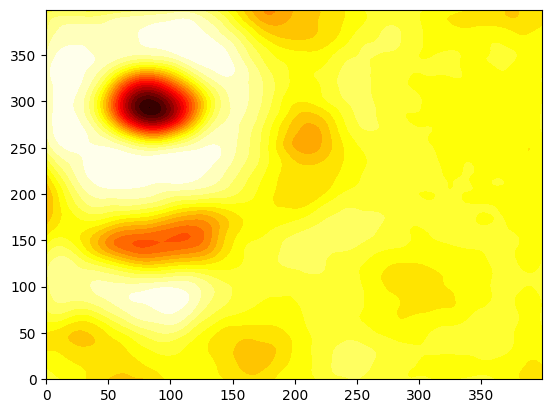

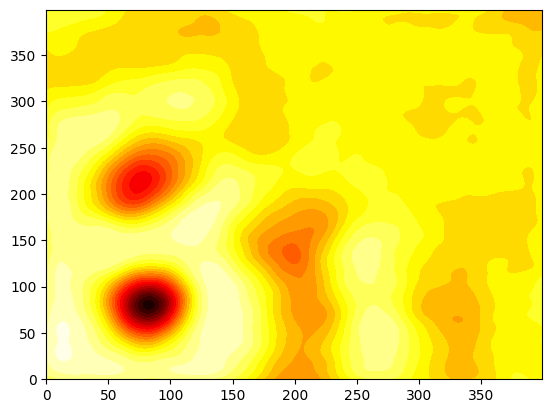

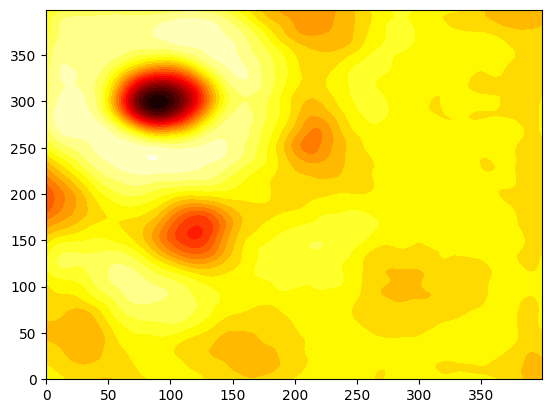

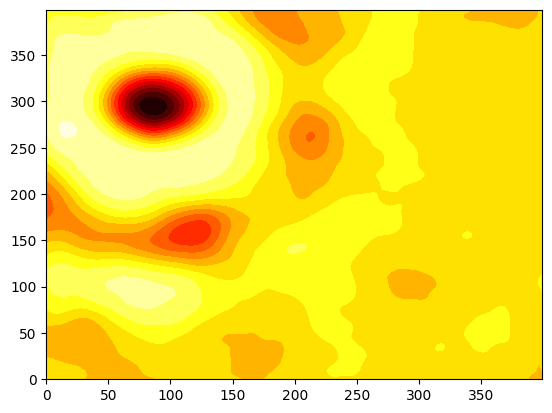

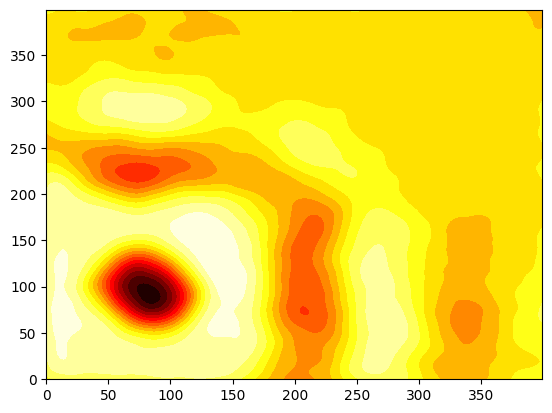

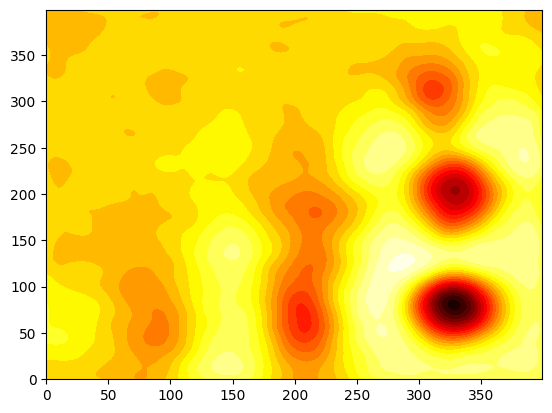

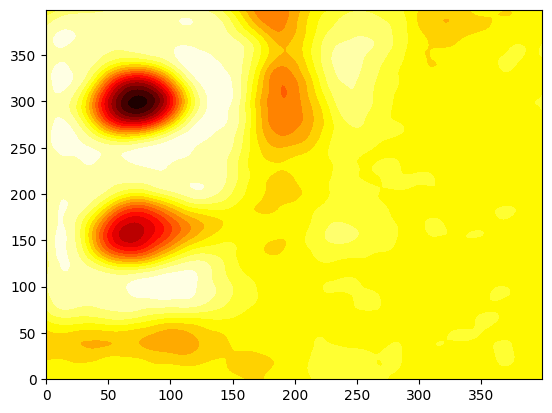

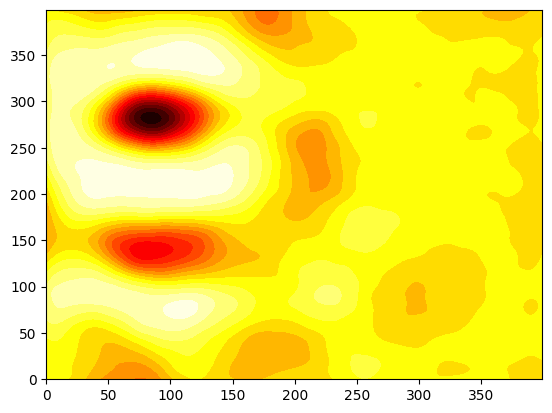

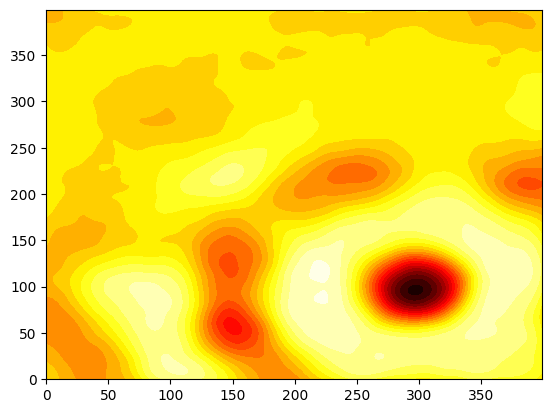

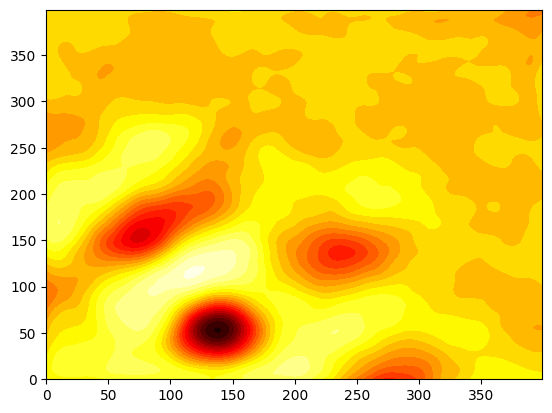

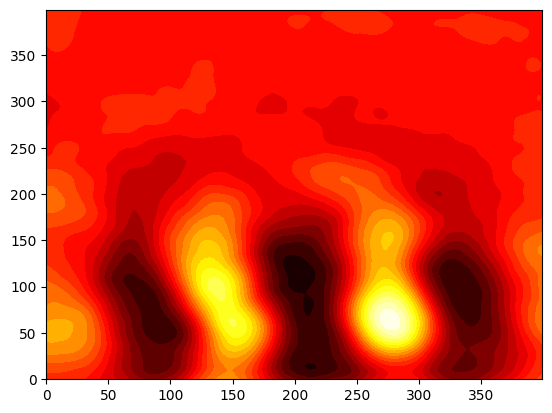

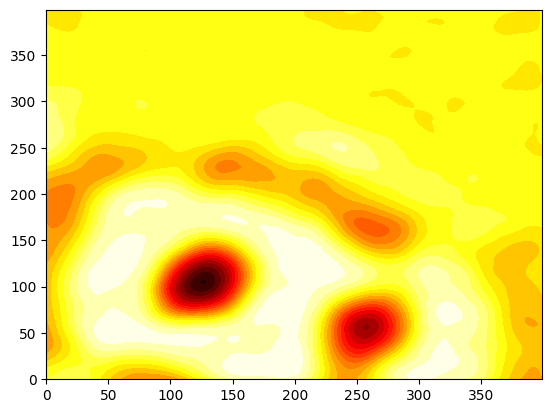

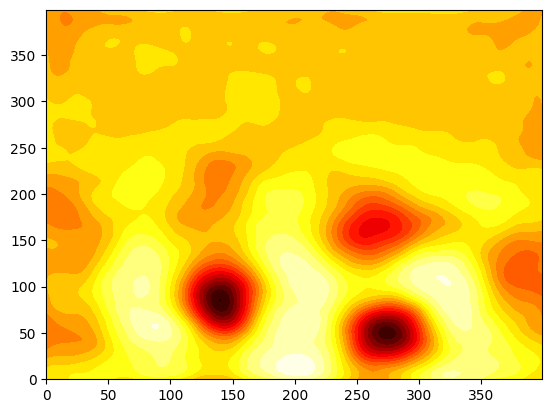

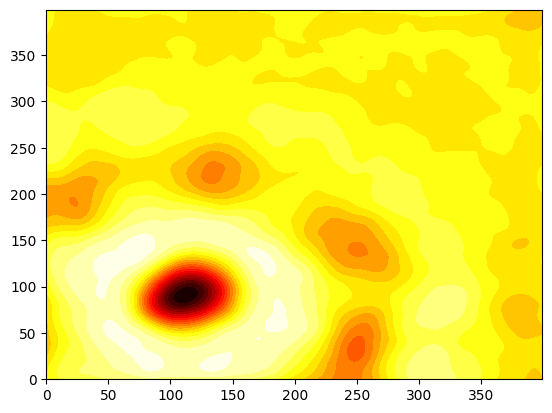

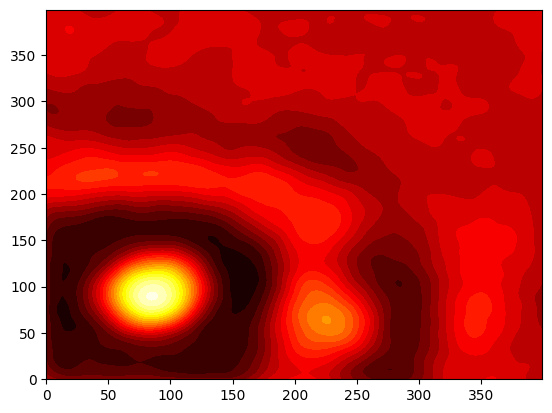

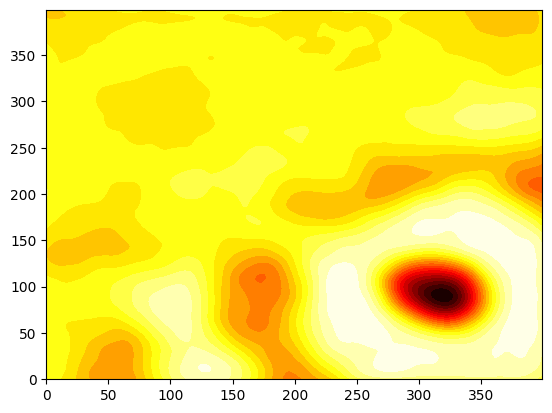

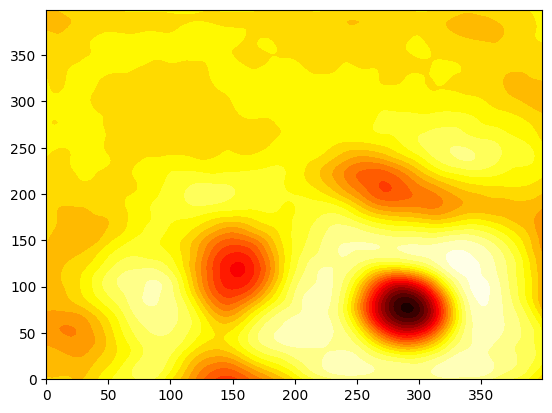

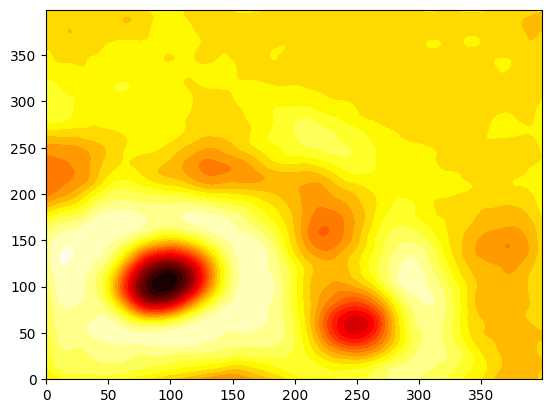

In [110]:
hidden = (gc @ net[0].weight.T).detach().cpu().numpy().transpose((-1, 0, 1))
idx = net[2].weight.detach().cpu().abs().argsort(dim=-1)[:,-10:]
for img in hidden[idx.flatten()]:
    plt.contourf(img, levels=20, cmap='hot')
    plt.show()

In [ ]:
n_episodes = 500
episode_max_len = 50

rewards = list()
lengths = list()
for ep in tqdm(range(n_episodes)):
    done = False
    step = 0
    reward = list()
    s = env.reset()
    while not done and step < episode_max_len:
        a = agent.choose_action(s)
        s_new, r, done = env.next_state(a)
        agent.remember(s, a, r, s_new, done)
        agent.learn()
        s = s_new
        step += 1
        reward.append(r)
    lengths.append(step)
    rewards.append(sum(reward))

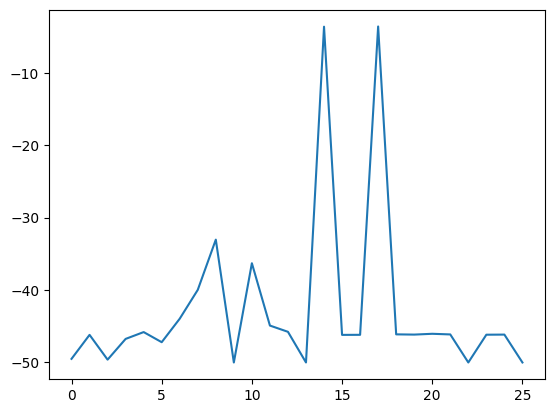

In [5]:
plt.plot(rewards)

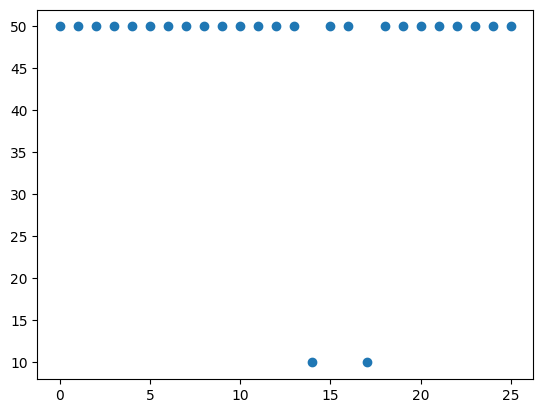

In [6]:
plt.scatter(np.arange(len(lengths)), lengths)

In [ ]:
states = []
s = env.reset()
env.state = np.array([0.5, -1])
s = env.grid_cells[env.closest_coord_index(env.state)]
states.append(env.state)
step = 0
done = False
while not done and step < episode_max_len:
    a = agent.choose_action(s, evaluate=True)
    s_new, r, done = env.next_state(a)
    s = s_new
    states.append(env.state)
    step += 1

In [ ]:
plt.plot(*np.asarray(states).T)